### Download the rvl_cdip Dataset: https://huggingface.co/datasets/aharley/rvl_cdip 


#### Reference:
Adam W Harley, Alex Ufkes, & Konstantinos G Derpanis 2015. Evaluation of Deep Convolutional Nets for Document Image Classification and Retrieval. https://huggingface.co/datasets/aharley/rvl_cdip 


In [59]:
from datasets import load_dataset
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

import numpy as np
import cv2
from PIL import Image


In [58]:
train_stream = load_dataset("aharley/rvl_cdip", split="train", streaming=True)

In [ ]:
labels = {
    0: "letter",
    1: "form",
    2: "email",
    3: "handwritten",
    4: "advertisement",
    5: "scientific report",
    6: "scientific publication",
    7: "specification",
    8: "file folder",
    9: "news article",
    10: "budget",
    11: "invoice",
    12: "presentation",
    13: "questionnaire",
    14: "resume",
    15: "memo"
}

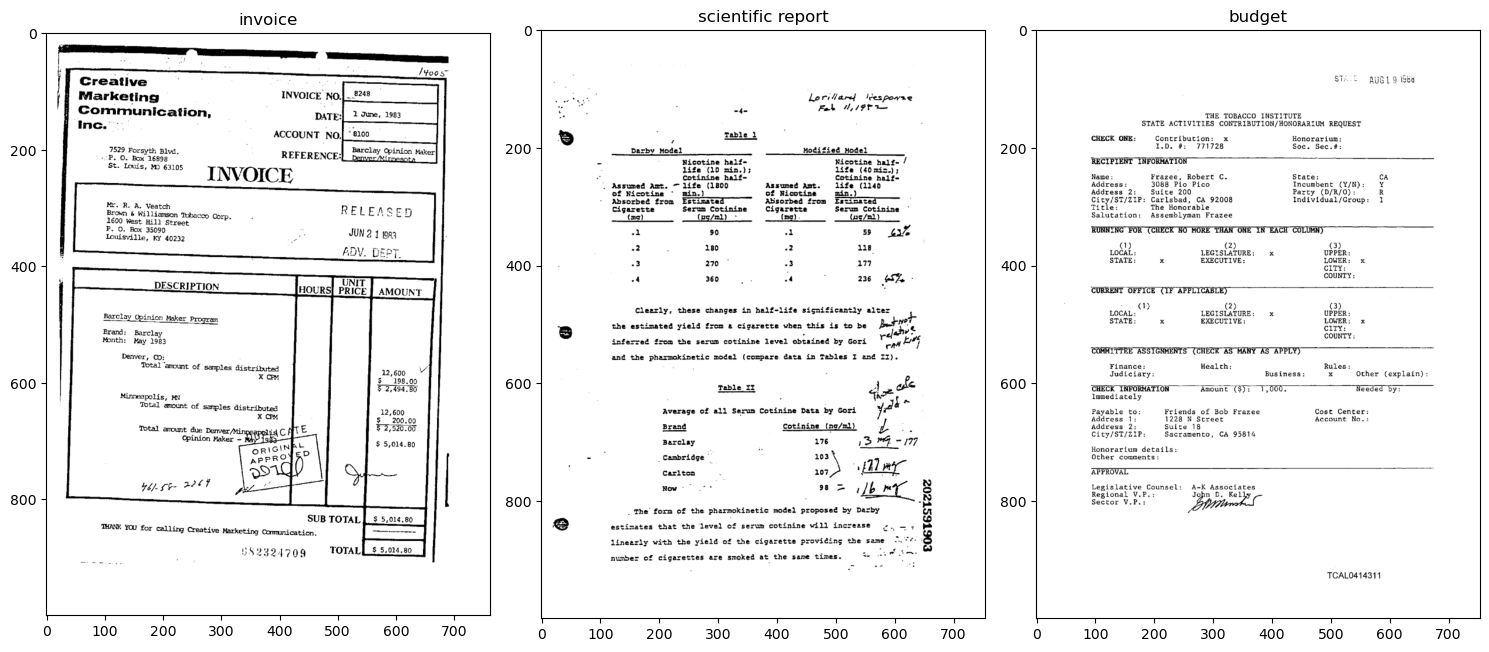

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))

for idx, sample  in enumerate(itertools.islice(train_stream, 3)):
    image = sample["image"]
    label = sample["label"]

    axs[idx].imshow(image, cmap="gray")
    axs[idx].set_title(f"{labels[label]}")

plt.tight_layout()
plt.show()

In [49]:
def smooth_warp_steps(img: Image.Image, num_steps: int = 6):
    img_np = np.array(img)
    h, w = img_np.shape[:2]

    # 1. Define source points (corners of image)
    src_pts = np.float32([[0, 0], [w, 0], [0, h], [w, h]])

    # 2. Create one set of final warped destination points
    max_jitter = int(0.5 * min(h, w))  # up to 25% warp
    dst_pts_final = np.float32([
        [np.random.randint(-max_jitter, max_jitter), np.random.randint(-max_jitter, max_jitter)],
        [w + np.random.randint(-max_jitter, max_jitter), np.random.randint(-max_jitter, max_jitter)],
        [np.random.randint(-max_jitter, max_jitter), h + np.random.randint(-max_jitter, max_jitter)],
        [w + np.random.randint(-max_jitter, max_jitter), h + np.random.randint(-max_jitter, max_jitter)],
    ])

    # 3. Generate warped images over timesteps
    warped_images = []
    for t in np.linspace(0, 1, num_steps):
        # Interpolating between src_pts and dst_pts_final at each timestep t
        dst_pts_t = (1 - t) * src_pts + t * dst_pts_final

        # Ensure that dst_pts_t is of type float32 for cv2.getPerspectiveTransform
        dst_pts_t = np.float32(dst_pts_t)

        # Compute perspective transform matrix
        M = cv2.getPerspectiveTransform(src_pts, dst_pts_t)
        warped = cv2.warpPerspective(img_np, M, (w, h), borderMode=cv2.BORDER_TRANSPARENT)

        warped_images.append(Image.fromarray(warped))

    return warped_images

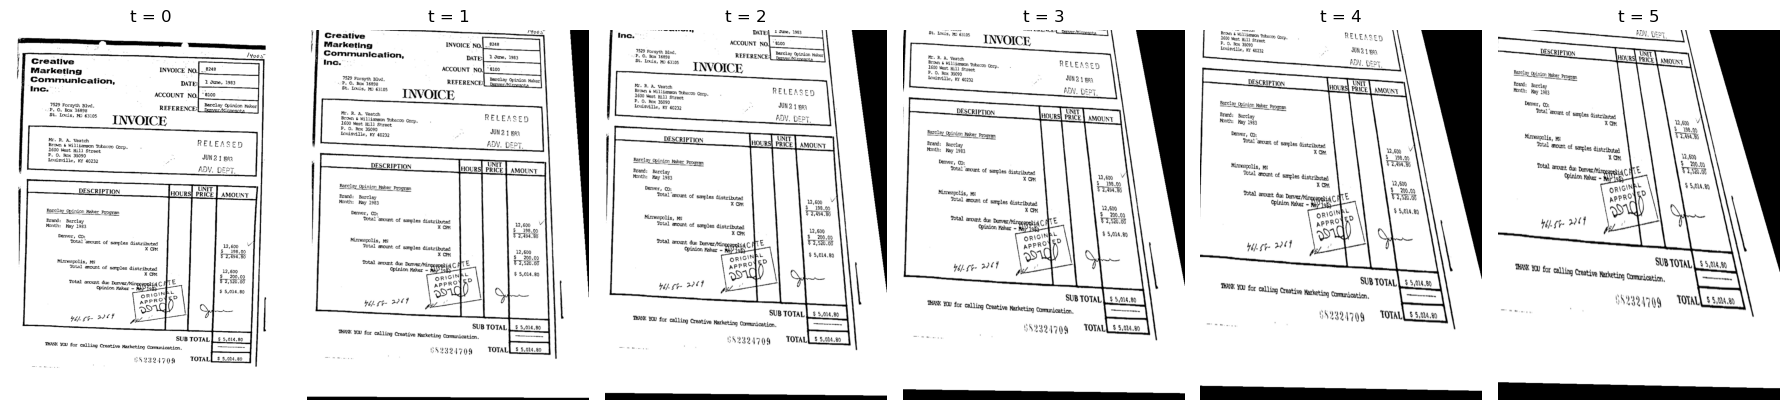

In [50]:
sample = next(iter(train_stream))  # Get one sample

num_steps = 6

warped_series = smooth_warp_steps(sample["image"].convert("RGB"), num_steps)

fig, axs = plt.subplots(1, len(warped_series), figsize=(18, 4))
for i, warped in enumerate(warped_series):
    axs[i].imshow(warped)
    axs[i].set_title(f"t = {i}")
    axs[i].axis("off")
    
plt.tight_layout()
plt.show()
